In [76]:
from importlib import reload
import pymongo
import gridfs
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
from scipy.sparse import csc_matrix, csr_matrix
import pickle
import pretty_midi
import sys
import copy
from collections import namedtuple
import timeit
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

In [101]:
# import modules, including a reload statement so that they can be reimported after a change to the methods 
import src.midi_utils as midi_utils
reload(midi_utils)

import src.data as data
reload(data)

import src.models as models
reload(models)

import src.ml_classes as ml_classes
reload(ml_classes)

<module 'src.ml_classes' from '/storage/781-piano-autoencoder/src/ml_classes.py'>

In [3]:
model_datas, seconds = data.folder2examples('training_data/midi_val', sparse=False, use_base_key=True, beats_per_ex=16)
model_datas_pred = copy.deepcopy(model_datas)

processing file 0 of 7
00h 38m 11s of data
created model data H :    (64, 88) data shape,     176 training examples
created model data O :    (64, 88) data shape,     176 training examples
created model data V :    (64, 88) data shape,     176 training examples
created model data R :    (64, 88) data shape,     176 training examples
created model data S :    (64, 2) data shape,     176 training examples
created model data key :    (12,) data shape,     176 training examples
created model data tempo :    (1,) data shape,     176 training examples
created model data V_mean :    (1,) data shape,     176 training examples


### Simple Bi LSTM Model

In [ ]:
model_input_reqs, model_output_reqs = models.get_model_reqs(['H', 'V_mean'], ['V'])

hidden_state = 256
lstm_layers = 2
dense_layers = 1
dense_size = 128
seq_model = models.create_simple_LSTM_RNN(model_input_reqs, model_output_reqs, seq_length=seq_length, dense_layers=dense_layers, dense_size=dense_size)
seq_model.summary()
tf.keras.utils.plot_model(seq_model)

# load some weights
seq_model.load_weights('89-0.31.hdf5')

#### Predict

In [50]:
V_pred = seq_model.predict({md.name + '_in': md.data for md in model_datas.values()})

# get predictions for indices where a note exists, or doesn't exist
V_pred_ones = V_pred[np.where(model_datas['H'].data == 1)]
V_pred_zeros = V_pred[np.where(model_datas['H'].data != 1)]

#### Some plotting of note velocity predictions: mostly zeros or ones

Text(0, 0.5, 'Frequency')

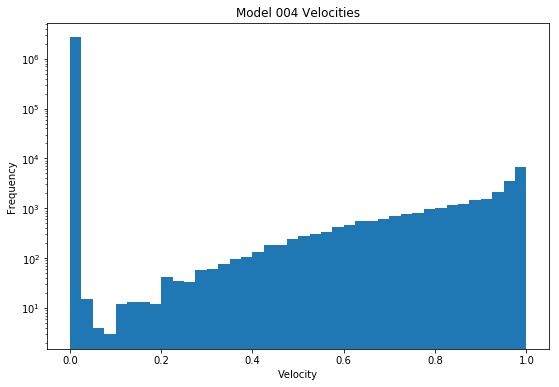

In [47]:
# plot frequencies of different velocities - we see that the model is biased towards predicting values close to 0 or 1
plt.figure(figsize=(9,6))
plt.yscale('log')
plt.hist(V_pred.flatten(), bins=40)
plt.title('Model 004 Velocities')
plt.xlabel('Velocity')
plt.ylabel('Frequency')
# plt.savefig('004-velocities')

Text(0, 0.5, 'Frequency')

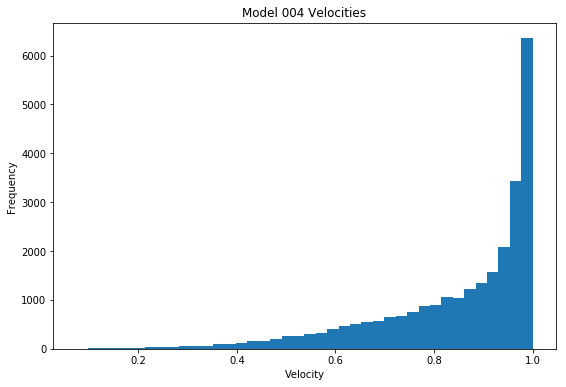

In [52]:
# how about plotting velocities for the positions where there are notes?
# all the zero velocity predictions are gone. I.e. this model is just learning to reproduce input.
plt.figure(figsize=(9,6))
# plt.yscale('log')
plt.hist(V_pred_ones, bins=40)
plt.title('Model 004 Velocities')
plt.xlabel('Velocity')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

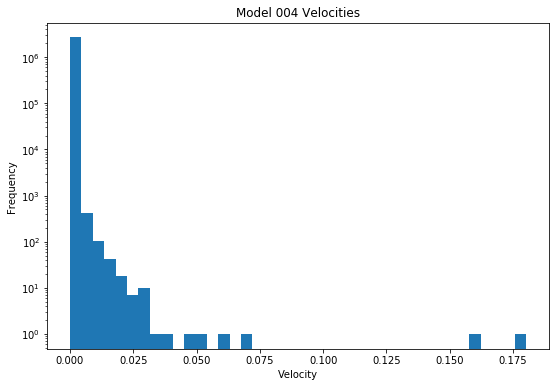

In [53]:
# velocities for positions where there are no notes
plt.figure(figsize=(9,6))
plt.yscale('log')
plt.hist(V_pred_zeros, bins=40)
plt.title('Model 004 Velocities')
plt.xlabel('Velocity')
plt.ylabel('Frequency')

#### look at correlation between real and predicted velocities

In [67]:
np.corrcoef(V_pred_ones, model_datas['V'].data[np.where(model_datas['H'].data == 1)])
# V_pred_ones.shape
# model_datas['V'].data[np.where(model_datas['H'].data == 1)]

array([[1.       , 0.4592872],
       [0.4592872, 1.       ]])

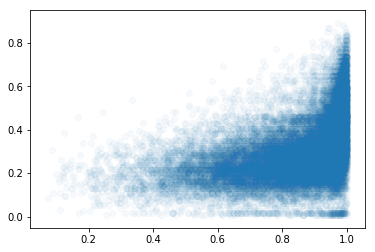

In [75]:
plt.scatter(V_pred_ones, model_datas['V'].data[np.where(model_datas['H'].data == 1)], alpha=0.03)

#### write predictions to midi

In [ ]:
model_datas['V'].data = V_pred
for i in range(10):
    pm = data.examples2pm(model_datas)
    pm.write(f'test{i}.mid')

### Simple Encoder Decoder

In [9]:
import src.models as models
reload(models)

# data params
model_inputs = ['H', 'V_mean']
model_outputs = ['H', 'V']
seq_length = 64
use_base_key = True
transpose = False
st = 0
nth_file = None

# network params
hierarchical = False
initial_state_from_dense = False
hidden_state = 512
lstm_layers = 2
dense_layers = 1
dense_size = 512
latent_size = 256
batch_size = 64
# ar_inputs only works as parameter for non hierarchical graph, currently
ar_inputs = None


model_input_reqs, model_output_reqs = models.get_model_reqs(model_inputs, model_outputs)


In [ ]:
z, model_inputs = models.create_LSTMencoder_graph(model_input_reqs, hidden_state_size=hidden_state, dense_size=dense_size, latent_size=latent_size, seq_length=seq_length)
encoder = tf.keras.Model(inputs=model_inputs, outputs=z, name=f'encoder')

z_input = tf.keras.Input(batch_shape=(1,)+z.shape[1:], name='z_in')

# must be stateful! With sequence length of 1.
pred, ar_inputs = models.create_LSTMdecoder_graph_ar(z_input, model_output_reqs, seq_length=1, hidden_state_size = hidden_state, dense_size=dense_size, stateful=True)

decoder = tf.keras.Model(inputs=[z_input] + ar_inputs, outputs=pred, name=f'decoder')

encoder.summary()
decoder.summary()

In [44]:
run = 59
encoder.load_weights(f'experiments/run_{run}/{run}_best_train_weights.hdf5', by_name=True)
decoder.load_weights(f'experiments/run_{run}/{run}_best_train_weights.hdf5', by_name=True)

In [45]:
# grab some examples, and predict z
idx = [0,45,70,100,125,150]
random_examples = {}

for md in model_datas.values():
    random_examples[md.name + '_in'] = md.data[idx,...]
    random_examples[md.name + '_in'] = random_examples[md.name + '_in']
    if md.seq:
        random_examples[md.name + '_ar'] = np.concatenate([np.zeros((len(idx),1, md.dim)), md.data[idx,...][:,:-1]], axis=-2)
z_pred = encoder.predict(random_examples)

In [50]:
# predict on z
pred = []
inputs = {}
# get required ar inputs from model datas - these are just zeros
for out in model_output_reqs:
    if out.seq:
        inputs[out.name + '_ar'] = np.zeros((1,1,out.dim))
print([f'{name}: {md_in.shape}' for name, md_in in inputs.items()])

# What will unavailable for prediction?
non_accessible = ['V']

filter_ar_pos = True # whether to set all ar inputs to zero for positions with no notes 
for j, z in enumerate(z_pred):
    decoder.reset_states()
    # get latent vector
    inputs['z_in'] = np.expand_dims(z, 0)
    outputs_pred = []
    # iterate over timesteps
    for i in range(seq_length):
        # get the ar inputs
        for out in model_output_reqs:
            # will only be ar inputs if seq is true
            # in practice, not all seq inputs might be required by the model - but the model will select these by name if they are all passed
            if out.seq and out.name not in non_accessible:
                # need to expand dims - it is still seq data, just with time step of one
                inputs[out.name + '_ar'] = np.expand_dims(np.expand_dims(random_examples[out.name + '_ar'][j,i], 0), 0)
        decoded = decoder.predict(inputs)
        # iterate over outputs - feed put them into inputs
        # ignores whether the model actually needs them all autoregressively!
        for output_name, output in zip(decoder.output_names, decoded):
            input_name = output_name.split('_')[0] + '_ar'
            if filter_ar_pos:
                # set positions where there are no notes to zero
                # this assumes that all outputs have same dimensions as H! i.e., 88
                # this might error out, because of extra dimension on output
                output[:,:,np.where(random_examples['H_in'][j,i] != 1)[0]] = 0
                inputs[input_name] = np.expand_dims(np.expand_dims(output, 0), 0)
            # give outputs back autoregressively
#             print(input_name)
#             print(output)
            inputs[input_name] = output
        # need to add here ar input, but taken from the original H - this is known, so why use the model output!
#         inputs['H_ar'] = random_examples['H_ar'][j,i]
        outputs_pred.append(np.squeeze(decoded))
    pred.append(outputs_pred)

['H_ar: (1, 1, 88)', 'V_ar: (1, 1, 88)']


In [ ]:
# find axis that corresponds to velocity
v_index = np.where(np.array(decoder.output_names) == 'V_out')[0][0]
print('v_index:', v_index)
print('predictions shape:', np.array(pred).shape)
model_datas_pred = copy.deepcopy(model_datas)
model_datas_pred['V'].data[idx,...] = np.array(pred)[:,:,v_index,:]
for i in idx:
    pm_original = data.examples2pm(model_datas, i)
    pm_pred = data.examples2pm(model_datas_pred, i)
    pm_original.write(f'experiments/run_{run}/ex{i}original.mid')
    pm_pred.write(f'experiments/run_{run}/ex{i}prediction.mid')

### Hierarchical Prediction

In [89]:
run = 216
client = pymongo.MongoClient()  # assuming a local MongoDB
fs = gridfs.GridFS(client.sacred)  # assuming database name is 'sacred'
runs = client.sacred.runs
# Now get run from the database
run_entry = runs.find_one({'_id': run})
config = run_entry['config']

In [90]:
model_datas, seconds = data.folder2examples('training_data/midi_val', sparse=False, use_base_key=True, beats_per_ex=int(config['seq_length'] / 4), vel_cutoff=config['vel_cutoff'])
model_datas_pred = copy.deepcopy(model_datas)

random_examples, idx = data.n_rand_examples(model_datas)

processing file 0 of 7
00h 38m 11s of data
created model data H :    (64, 88) data shape,     176 training examples
created model data O :    (64, 88) data shape,     176 training examples
created model data V :    (64, 88) data shape,     176 training examples
created model data R :    (64, 88) data shape,     176 training examples
created model data S :    (64, 2) data shape,     176 training examples
created model data key :    (12,) data shape,     176 training examples
created model data tempo :    (1,) data shape,     176 training examples
created model data V_mean :    (1,) data shape,     176 training examples


#### predict using teacher forcing

In [91]:
model_input_reqs, model_output_reqs = models.get_model_reqs(**config)
z, model_inputs = models.create_LSTMencoder_graph(model_input_reqs, **config)
if config['variational']:
    sampling_fn = models.sampling(**config)
    z = layers.Lambda(sampling_fn)(z)

# a few other 
config['stateful'] = False
config['ar_inc_batch_shape'] = True
# config['batch_size'] = 1

if config['hierarchical']:
    pred, ar_inputs = models.create_hierarchical_decoder_graph(z, model_output_reqs, **config)
else:
    pred, ar_inputs = models.create_LSTMdecoder_graph_ar(z, model_output_reqs, **config)
autoencoder = tf.keras.Model(inputs=model_inputs + ar_inputs, outputs=pred, name=f'autoencoder')

z type: <class 'tensorflow.python.framework.ops.Tensor'>
Tensor("z_17/Identity:0", shape=(None, 256), dtype=float32)
conductor substeps: 16


In [94]:
models.load_weights_safe(autoencoder, f'experiments/run_{run}/{run}_best_val_weights.hdf5', by_name=False)

weights loaded successfully


For non teacher forced prediction, there might be trouble with layer names. We can address this be saving weights from the autoencoder we just made - that newly saved version should have updated layer names. 

In [95]:
# autoencoder.save_weights(f'experiments/run_{run}/{run}_best_val_weights.hdf5')

In [81]:
pred = autoencoder.predict(random_examples)
# find axis that corresponds to velocity
v_index = np.where(np.array(autoencoder.output_names) == 'V_out')[0][0]
print('velocity index:', v_index)
model_datas_pred = copy.deepcopy(model_datas)
model_datas_pred['V'].data[idx,...] = np.array(pred)[v_index,:,:,:]
for i in idx:
    pm_original = data.examples2pm(model_datas, i)
    pm_pred = data.examples2pm(model_datas_pred, i)
    pm_original.write(f'experiments/run_{run}/ex{i}original.mid')
    pm_pred.write(f'experiments/run_{run}/ex{i}prediction_teacher_forced.mid')

v_index: 1
predictions shape: (2, 7, 64, 88)
example 0 chosen
example 0 chosen
example 45 chosen
example 45 chosen
example 70 chosen
simultaneous pedal events!
example 70 chosen
simultaneous pedal events!
example 100 chosen
simultaneous pedal events!
example 100 chosen
simultaneous pedal events!
example 125 chosen
example 125 chosen
example 150 chosen
example 150 chosen
example 155 chosen
example 155 chosen


#### predict the hard way

In [96]:
model_input_reqs, model_output_reqs = models.get_model_reqs(**config)
z, model_inputs = models.create_LSTMencoder_graph(model_input_reqs, **config)
if config['variational']:
    sampling_fn = models.sampling(**config)
    z = layers.Lambda(sampling_fn)(z)

config['stateful'] = True
config['ar_inc_batch_shape'] = True
config['batch_size'] = 1
if config['hierarchical']:
    conductor_out, ar_inputs, decoder = models.create_hierarchical_decoder_graph(z, model_output_reqs, **config)
else:
    pred, ar_inputs = models.create_LSTMdecoder_graph_ar(z, model_output_reqs, **config)
autoconductor = tf.keras.Model(inputs=[model_inputs, ar_inputs], outputs=conductor_out, name=f'autoconductor')
# autoconductor.summary()

z type: <class 'tensorflow.python.framework.ops.Tensor'>
Tensor("z_18/Identity:0", shape=(None, 256), dtype=float32)
conductor substeps: 16


In [97]:
# load some weights
models.load_weights_safe(autoconductor, f'experiments/run_{run}/{run}_best_train_weights.hdf5')
models.load_weights_safe(decoder, f'experiments/run_{run}/{run}_best_train_weights.hdf5')
# pred = autoencoder.predict(random_examples)

weights loaded successfully
weights loaded successfully


In [98]:
auto_conductor_outs = autoconductor.predict(random_examples)

In [99]:
conductor_substeps = int(config['seq_length'] / config['conductor_steps'])

# predict on z
pred = []
inputs = {}
# get required ar inputs from model datas - these are just zeros
for out in model_output_reqs:
    if out.seq:
        inputs[out.name + '_ar'] = np.zeros((1,1,out.dim))
print([f'{name}: {md_in.shape}' for name, md_in in inputs.items()])

# What will unavailable for prediction?
non_accessible = []

filter_ar_pos = False # whether to set all ar inputs to zero for positions with no notes 
for i, auto_out in enumerate(zip(*auto_conductor_outs)):
    print(f'Example {i + 1} of {len(idx)}')
    decoder.reset_states()
    outputs_pred = []
    # iterate over timesteps
    for c_step in range(config['conductor_steps']):
        for c_substep in range(conductor_substeps):
            t = c_step * conductor_substeps + c_substep
            if c_substep == 0:
                # get conductor output
                inputs['c_in'] = np.expand_dims(np.expand_dims(auto_out[0][c_step], 0), 0)
                # set initial states of decoder LSTMs
                for k in range(config['decoder_lstms']):
                    tf.keras.backend.set_value(decoder.get_layer(f'final_dec_LSTM_{k}').states[0], np.expand_dims(auto_out[k*2 + 1][c_step], 0))
                    tf.keras.backend.set_value(decoder.get_layer(f'final_dec_LSTM_{k}').states[1], np.expand_dims(auto_out[k*2 + 2][c_step], 0))
            # get the ar inputs
            for out in model_output_reqs:
                # will only be ar inputs if seq is true
                # in practice, not all seq inputs might be required by the model - but the model will select these by name if they are all passed
                if out.seq and out.name not in non_accessible:
                    # need to expand dims - it is still seq data, just with time step of one
                    inputs[out.name + '_ar'] = np.expand_dims(np.expand_dims(random_examples[out.name + '_ar'][i,t], 0), 0)
            decoded = decoder.predict(inputs)
            # iterate over outputs - feed put them into inputs
            # ignores whether the model actually needs them all autoregressively!
            for output_name, output in zip(decoder.output_names, decoded):
                input_name = output_name.split('_')[0] + '_ar'
                if filter_ar_pos:
                    # set positions where there are no notes to zero
                    # this assumes that all outputs have same dimensions as H! i.e., 88
                    output[...,np.where(random_examples['H_in'][i,t] != 1)[0]] = 0
                    inputs[input_name] = np.squeeze(output, 0)
                else:
                    inputs[input_name] = np.squeeze(output, 0)
            outputs_pred.append(np.squeeze(decoded))
    pred.append(outputs_pred)

['H_ar: (1, 1, 88)', 'V_ar: (1, 1, 88)']
Example 1 of 7
Example 2 of 7
Example 3 of 7
Example 4 of 7
Example 5 of 7
Example 6 of 7
Example 7 of 7


In [176]:
for t in range(32):
    print(min(np.array(pred)[0,t,v_index,:]), max(np.array(pred)[0,t,v_index,:]) - min(np.array(pred)[0,t,v_index,:]))

0.056355577 0.58537006
0.0003333131 0.7658558
8.6137254e-07 0.79865694
3.2935257e-09 0.74580306
4.479436e-10 0.40546697
3.1349318e-10 0.20859146
9.169144e-10 0.04046169
6.9292233e-10 0.040657714
7.279959e-10 0.102374025
1.7791407e-10 0.18263009
1.2397801e-10 0.32187647
1.9798749e-10 0.28087282
6.560482e-10 0.101506636
7.3796386e-10 0.11676683
6.036737e-10 0.61226434
4.5164028e-10 0.81807166
0.04536759 0.43656132
0.00012126717 0.7182938
4.503272e-08 0.79252887
4.5302587e-10 0.3014332
1.1710966e-10 0.077454835
2.3182957e-10 0.007839957
2.7951097e-09 0.0011713231
7.889444e-10 0.16174355
1.0188825e-09 0.64991623
3.1099126e-10 0.356365
2.4561064e-10 0.19577669
6.81502e-10 0.045391347
8.9697844e-10 0.005762999
1.2674637e-09 0.020108834
1.0524612e-09 0.007321949
1.1856681e-09 0.024084209


In [100]:
# find axis that corresponds to velocity
v_index = np.where(np.array(decoder.output_names) == 'V_unconcat')[0][0]
print('v_index:', v_index)
print('predictions shape:', np.array(pred).shape)
model_datas_pred = copy.deepcopy(model_datas)
model_datas_pred['V'].data[idx,...] = np.array(pred)[:,:,v_index,:]
for i in idx:
    pm_original = data.examples2pm(model_datas, i)
    pm_pred = data.examples2pm(model_datas_pred, i)
    pm_original.write(f'experiments/run_{run}/ex{i}original.mid')
    pm_pred.write(f'experiments/run_{run}/run_{run}_ex{i}prediction.mid')

v_index: 1
predictions shape: (7, 64, 2, 88)
example 0 chosen
example 0 chosen
example 45 chosen
example 45 chosen
example 70 chosen
simultaneous pedal events!
example 70 chosen
simultaneous pedal events!
example 100 chosen
simultaneous pedal events!
example 100 chosen
simultaneous pedal events!
example 125 chosen
example 125 chosen
example 150 chosen
example 150 chosen
example 155 chosen
example 155 chosen


In [98]:
run

134

In [34]:
for layer in decoder.layers:
    print(layer.name)

H_ar
V_ar
c_in
concatenate_7
concatenate_8
final_dec_LSTM_0
final_dec_LSTM_1
expand_dims
H_unconcat
V_unconcat


In [66]:
def harry(a, s, c=0,d=0, **aas):
    print(a,s,c,d)
    print(aas)

inputs = {'b':2,'a':1,  'c':3, 'd':4, 's':  4}
harry(100, **inputs)
print(inputs)

TypeError: harry() got multiple values for argument 'a'

In [32]:
client = pymongo.MongoClient()  # assuming a local MongoDB
fs = gridfs.GridFS(client.sacred)  # assuming database name is 'sacred'

runs = client.sacred.runs
# Now get run from the database
run_entry = runs.find_one({'_id': 134})  # BTW: you can query by whatever you want here.

# can always get weights like this, but need to write them to a temp file before loading
# weights = fs.get(run_entry['artifacts'][0]['file_id']).read()
print(run_entry['config'])

{'model_inputs': ['H', 'V_mean'], 'model_outputs': ['H', 'V'], 'seq_length': 32, 'use_base_key': True, 'transpose': False, 'st': 0, 'nth_file': None, 'vel_cutoff': 4, 'hierarchical': True, 'variational': False, 'latent_size': 256, 'hidden_state': 512, 'dense_size': 512, 'dense_layers': 2, 'recurrent_dropout': 0.0, 'encoder_lstms': 2, 'z_activation': None, 'epsilon_std': 1, 'decoder_lstms': 2, 'ar_inputs': None, 'conductors': 2, 'conductor_steps': 2, 'conductor_state_size': None, 'initial_state_from_dense': True, 'initial_state_activation': 'tanh', 'batch_size': 64, 'lr': 0.0001, 'epochs': 350, 'monitor': 'loss', 'free_bits': 0, 'clipvalue': 1, 'loss': 'categorical_crossentropy', 'kl_weight': 1, 'metrics': ['accuracy', 'categorical_crossentropy'], 'continue_run': 133, 'log_tensorboard': False, 'seed': 15782944}


In [63]:
# use set for setting fields. unset removes fields.
# This example finds runs with id <= 146, with field config.z_activation, and updates the field to relu
runs.update_many({'_id': {'$lte': 146}, 'config.z_activation': {'$exists': True}}, {
  '$set': {
    'config.z_activation': 'relu'
  }}
    )
# print(runs.find_one({'_id': 146})['config']['z_activation'])

In [64]:

# find runs where datatype of seconds_train_data is float64
run_csr = runs.find({'_id': { '$lte': 146}, 'config.z_activation': {'$exists': True}})
for run in run_csr:
    print(run['_id'])
    print(run['config'].get('z_activation', 'Not included'))


60
relu
66
relu
80
relu
81
relu
82
relu
88
relu
89
relu
92
relu
93
relu
94
relu
117
relu
121
relu
124
relu
126
relu
127
relu
130
relu
133
relu
134
relu
136
relu
139
relu
140
relu
141
relu
145
relu
146
relu


In [26]:
run_entry2 = runs.find_one({'_id': { '$lt': 100}})
pp.pprint([i for i in run_entry2.keys()])

['_id',
 'experiment',
 'format',
 'command',
 'host',
 'start_time',
 'config',
 'meta',
 'status',
 'resources',
 'artifacts',
 'captured_out',
 'info',
 'heartbeat',
 'result',
 'stop_time',
 'omniboard']
